# Mapping Tree Species Across the Petawawa Research Forest using LiDAR

In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import rasterio
from rasterio.plot import show
import contextily as cx
from matplotlib import pyplot as plt


Load the dataset below. This reads data regarding the Petawawa Research Forest.

In [18]:
# Load data and set filepaths
als_metrics = r'data/petawawa_species/als_metrics.tif'

plot_locs_fpath = r'data/petawawa_species/plot_locations.gpkg'
plots_xy = (gpd.read_file(plot_locs_fpath)
            .rename(columns={'Plot': 'plot_id'}))

prf_boundary_fpath = r'data/petawawa_species/prf_boundary.gpkg'
prf_boundary = gpd.read_file(prf_boundary_fpath)

sp_codes = r'data/petawawa_species/sp_codes.csv'
sp_codes_df = pd.read_csv(sp_codes).rename(columns={'Name': 'species'})

plot_data_fpath = r'data/petawawa_species/plot_data.xlsx'
plots_df = (pd.read_excel(plot_data_fpath, sheet_name='Plotsum')
            .rename(columns={'Leadsp': 'MNR Code',
                             'PlotName': 'plot_id'})
            .merge(sp_codes_df, how='left', on='MNR Code'))

# Join with the species DF
plots_xy = plots_xy.merge(plots_df, how='left', on='plot_id')

plots_df.head()

,plot_id,Status,BA_all,TPH_all,DCD_Count,PlantProp,origin,tvol,mvol,ba_merch,...,HL_all,HL_merch,FU,MurrayFU,dbhmax,dbh95,dbhq_all,dbhq_merch,species,MNR Species
0,PRF001,D,0.251353,32,NaN,1.00000,P,1.381989,0.000000,0.251353,...,11.488825,11.488825,NaN,Dead,10.1,10.1,10.000500,10.000500,White pine,PW
1,PRF001,L,33.601655,2688,4.0,0.22592,N,323.132202,241.738524,29.076337,...,22.944812,24.935425,PWus,PwPr,67.5,51.5,12.615959,18.446329,White pine,PW
2,PRF002,L,44.127504,15392,7.0,0.00000,N,353.671565,298.646059,25.101346,...,19.961161,30.817948,PWus,PwPr,60.2,51.2,6.041735,40.799275,White pine,PW
3,PRF003,D,3.615982,96,NaN,0.00000,N,28.793416,26.305051,3.615982,...,20.624830,20.624830,NaN,Dead,39.2,39.2,21.899391,21.899391,White spruce,SW
4,PRF003,L,28.489549,784,20.0,0.00000,N,253.695027,223.463661,28.489549,...,19.994438,19.994438,MXHcc,MIXEDH,44.6,36.0,21.509945,21.509945,Trembling Aspen,PT


Let's map the location of Petawawa to get a sense of the surrounding geography.

Text(0.5, 1.0, 'Petawawa Research Forest')

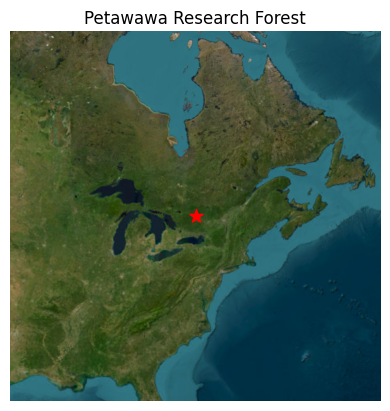

In [3]:
# View petawawa location

prf_boundary.centroid[0]
prf_center = gpd.GeoSeries(prf_boundary.centroid[0], crs=prf_boundary.crs)

prf_buf = prf_boundary.copy()
prf_buf.geometry = prf_buf.geometry.buffer(1_750_000, cap_style='square')

fig, ax = plt.subplots()
prf_buf.plot(ax=ax, facecolor='none', edgecolor='none')
prf_center.plot(ax=ax, color='red', marker='*', markersize=100)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,
                attribution="", crs=prf_boundary.crs)

plt.title('Petawawa Research Forest')

This code opens a raster dataset (`als_metrics`) using Rasterio, extracts metadata like band names and the coordinate reference system, and then reads the second raster band (here representing mean height values). 

It then uses Matplotlib to display that band as an image, coloring values with the viridis colormap. The axis ticks are removed for a cleaner look, and a colorbar is added to show that pixel values correspond to mean height in meters.

('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60', 'b70', 'b80', 'b90', 'dns_10m', 'dns_12m', 'dns_14m', 'dns_15m', 'dns_16m', 'dns_18m', 'dns_20m', 'dns_25m', 'dns_2m', 'dns_4m', 'dns_5m', 'dns_6m', 'dns_8m', 'kur_95', 'p01', 'p05', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p99', 'qav', 'skew_95', 'd0_2', 'd10_12', 'd12_14', 'd14_16', 'd16_18', 'd18_20', 'd20_22', 'd22_24', 'd24_26', 'd26_28', 'd28_30', 'd2_4', 'd30_32', 'd32_34', 'd34_36', 'd36_38', 'd38_40', 'd40_42', 'd42_44', 'd44_46', 'd46_48', 'd4_6', 'd6_8', 'd8_10', 'std_95', 'vci_1mbin', 'vci_0.5bin')


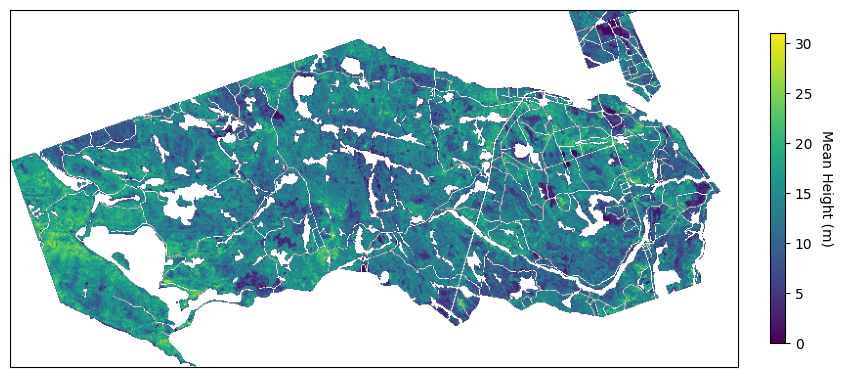

In [ ]:
with rasterio.open(als_metrics) as src:
    band_names = src.descriptions

    prf_crs = src.crs

    print(band_names)

    mn_z = src.read(2)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(mn_z, cmap='viridis')

ax.set_xticks([])
ax.set_yticks([])

cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('Mean Height (m)', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=10)

This code below visualizes survey plot locations within their boundary on a satellite basemap. Plots are coloured by dominant tree species.

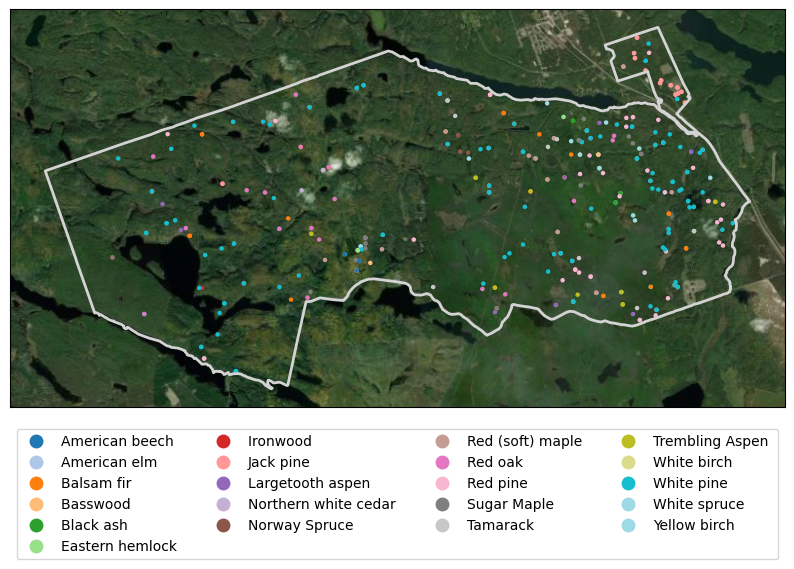

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax = plots_xy.plot(ax=ax, column='species', markersize=5, legend=True,
                     legend_kwds={'loc': 'lower center', 'fontsize': 10, 'ncol': 4, 'bbox_to_anchor': (0.5, -0.4)},
                     cmap = 'tab20')

prf_boundary.plot(ax=ax, facecolor='none', edgecolor='lightgrey', linewidth=2)

cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,
               attribution="", crs=plots_xy.crs)

ax.set_xticks([])
ax.set_yticks([])